In [2]:
import sys
sys.path.append('../src')
import scipy.io
import numpy as np
import pandas as pd
import logging
from scipy.optimize import minimize
from world import Patch, Agent
from mvt_brr import MVTModel
from utils import calculate_leave_statistics
from scipy.optimize import minimize_scalar
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

In [189]:
colors = ['#FFC300', '#FF5733', '#C70039']  # Light orange to dark orange

class Simulation:
    def __init__(self, decay_rate, model, beta_values=None, intercept_values=None, epsilon_values=None, omega_values=None):
        self.decay_rate = decay_rate
        self.beta_values = beta_values if model == 'softmax' else None
        self.intercept_values = intercept_values if model == 'softmax' else None
        self.epsilon_values = epsilon_values if model == 'epsilon_greedy' else None
        self.omega_values = omega_values if model == 'mellowmax' else None
        self.model = model
        self.patch_types, self.rich_proportions, self.poor_proportions = self.initialize_env()

    def initialize_env(self):
        patch_types = [
            {'type': 'Low', 'initial_yield': 32.5, 'decay_rate': self.decay_rate},
            {'type': 'Mid', 'initial_yield': 45, 'decay_rate': self.decay_rate},
            {'type': 'High', 'initial_yield': 57.5, 'decay_rate': self.decay_rate}
        ]
        rich_proportions = [0.2, 0.3, 0.5]
        poor_proportions = [0.5, 0.3, 0.2]
        return patch_types, rich_proportions, poor_proportions

    def compute_analytical_stats(self, patch_id, parameter, intercept, mellowmax_type='add'):
        patch = Patch(patch_id['initial_yield'], patch_id['decay_rate'])
        expected_leave_time, std_leave_time = calculate_leave_statistics(
            policy_type=self.model,
            parameter=parameter,
            intercept=intercept,
            patch=patch,
            mellowmax_type=mellowmax_type,
            use_intercept=True
        )
        return expected_leave_time, std_leave_time ** 2  # Return variance

    def plot_softmax_metric_vs_beta_and_intercept(self, metric='mean', save_plots=False):
        if metric not in ['mean', 'std']:
            raise ValueError("Metric must be either 'mean' or 'std'.")

        # Run the MVT model to get the MVT rich and poor values
        mvt_model = MVTModel(decay_type='exponential')
        MVT_rich, MVT_poor = mvt_model.run()

        # Find optimal beta and intercept for rich and poor environments
        optimal_params = self.find_optimal_parameters(self.patch_types, MVT_rich, MVT_poor)
        optimal_beta_rich, optimal_intercept_rich, optimal_beta_czero_rich = optimal_params['rich']
        print(f"Rich:{optimal_beta_rich}, {optimal_intercept_rich}")
        optimal_beta_poor, optimal_intercept_poor, optimal_beta_czero_poor = optimal_params['poor']
        print(f"Poor:{optimal_beta_poor}, {optimal_intercept_poor}")
        
        # Transposed layout: 2 columns, 2 rows
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        # Plot 1: Metric vs. Beta (with intercept = -2)
        intercept_fixed = 0
        betas = np.logspace(-2, 0, 100)
        for patch_id, color in zip(self.patch_types, colors):
            metrics = []
            for beta in betas:
                mean_time, std_time = self.compute_analytical_stats(patch_id, beta, intercept_fixed)
                if metric == 'mean':
                    metrics.append(mean_time)
                elif metric == 'std':
                    metrics.append(std_time)

            axes[0, 0].plot(betas, metrics, label=f'{patch_id["type"]}', color=color, linewidth=2)

        axes[0, 0].set_xscale('log')
        axes[0, 0].set_xlabel(r'$\beta$ (higher = exploit)', fontsize=15)
        axes[0, 0].set_ylabel(f'{"Expected leave time (s)" if metric == "mean" else "SD of leave time (s)"}', fontsize=15)
        # axes[0, 0].legend(fontsize=15)
        axes[0, 0].spines['top'].set_visible(False)
        axes[0, 0].spines['right'].set_visible(False)
        axes[0, 0].text(0.05, 0.9, fr'$c = {intercept_fixed}$', transform=axes[0, 0].transAxes, fontsize=15, verticalalignment='top')

        # Plot the vertical lines for optimal beta (separate for rich and poor)
        axes[0, 0].axvline(x=optimal_beta_czero_rich, color='blue', linestyle='--', label='Optimal Beta (Rich)')
        axes[0, 0].axvline(x=optimal_beta_czero_poor, color='green', linestyle='--', label='Optimal Beta (Poor)')

        # Add text labels beside the vertical lines for the first plot (intercept = 0)
        axes[0, 0].text(optimal_beta_czero_poor-0.02, 0.9, r'$\beta_{\text{rich}}$', color='blue', fontsize=15, ha='right', va='bottom', transform=axes[0, 0].get_xaxis_transform())
        axes[0, 0].text(optimal_beta_czero_poor+0.15, 0.9, r'$\beta_{\text{poor}}$', color='green', fontsize=15, ha='right', va='bottom', transform=axes[0, 0].get_xaxis_transform())

        # Plot 3: MVT vs Predictions at Optimal Beta and Fixed Intercept for Rich and Poor
        for idx, (optimal_beta, MVT_values, label, color) in enumerate([
            (optimal_beta_czero_rich, MVT_rich, 'Rich', 'blue'),
            (optimal_beta_czero_poor, MVT_poor, 'Poor', 'green')
        ]):
            predictions = [
                self.compute_analytical_stats(patch_id, optimal_beta, intercept_fixed)[0]
                for patch_id in self.patch_types
            ]
            axes[1, 0].plot(['Low', 'Mid', 'High'], MVT_values, marker='o', linestyle='--', color=color, label=f'MVT {label}')
            axes[1, 0].plot(['Low', 'Mid', 'High'], predictions, marker='o', linestyle='-', color=color, label=fr'$\beta_{label}$')

        axes[1, 0].set_xlabel('Patch Types', fontsize=15)
        axes[1, 0].set_ylabel('Mean Leave Time (s)', fontsize=15)
        # axes[1, 0].legend(fontsize=15)
        axes[1, 0].spines['top'].set_visible(False)
        axes[1, 0].spines['right'].set_visible(False)

        # Plot 1: Metric vs. Beta (with intercept = -2)
        intercept_fixed = -2
        betas = np.logspace(-2, 0, 100)
        for patch_id, color in zip(self.patch_types, colors):
            metrics = []
            for beta in betas:
                mean_time, std_time = self.compute_analytical_stats(patch_id, beta, intercept_fixed)
                if metric == 'mean':
                    metrics.append(mean_time)
                elif metric == 'std':
                    metrics.append(std_time)

            axes[0, 1].plot(betas, metrics, label=f'{patch_id["type"]} Patch', color=color, linewidth=2)

        axes[0, 1].set_xscale('log')
        axes[0, 1].set_xlabel(r'$\beta$ (higher = exploit)', fontsize=15)
        axes[0, 1].set_ylabel(f'{"Expected leave time (s)" if metric == "mean" else "SD of leave time (s)"}', fontsize=15)
        # axes[0, 1].legend()
        axes[0, 1].spines['top'].set_visible(False)
        axes[0, 1].spines['right'].set_visible(False)
        axes[0, 1].text(0.05, 0.9, fr'$c = {intercept_fixed}$', transform=axes[0, 1].transAxes, fontsize=15, verticalalignment='top')

        # Plot the vertical lines for optimal beta (separate for rich and poor)
        axes[0, 1].axvline(x=optimal_beta_rich, color='blue', linestyle='--', label='Optimal Beta (Rich)')
        axes[0, 1].axvline(x=optimal_beta_poor, color='green', linestyle='--', label='Optimal Beta (Poor)')

        axes[0, 1].text(optimal_beta_rich-0.02, 0.9, r'$\beta_{\text{rich}}$', color='blue', fontsize=15, ha='right', va='bottom', transform=axes[0, 1].get_xaxis_transform())
        axes[0, 1].text(optimal_beta_poor+0.35, 0.9, r'$\beta_{\text{poor}}$', color='green', fontsize=15, ha='right', va='bottom', transform=axes[0, 1].get_xaxis_transform())

        # Plot 3: MVT vs Predictions at Optimal Beta and Fixed Intercept for Rich and Poor
        for idx, (optimal_beta, MVT_values, label, color) in enumerate([
            (optimal_beta_rich, MVT_rich, 'Rich', 'blue'),
            (optimal_beta_poor, MVT_poor, 'Poor', 'green')
        ]):
            predictions = [
                self.compute_analytical_stats(patch_id, optimal_beta, intercept_fixed)[0]
                for patch_id in self.patch_types
            ]
            axes[1, 1].plot(['Low', 'Mid', 'High'], MVT_values, marker='o', linestyle='--', color=color)
            axes[1, 1].plot(['Low', 'Mid', 'High'], predictions, marker='o', linestyle='-', color=color)

        axes[1, 1].set_xlabel('Patch Types', fontsize=15)
        axes[1, 1].set_ylabel('Mean Leave Time (s)', fontsize=15)
        # axes[1, 1].legend(fontsize=15)
        axes[1, 1].spines['top'].set_visible(False)
        axes[1, 1].spines['right'].set_visible(False)

        # Plot 2: Metric vs. |Intercept| (with beta = 0.4)
        beta_fixed = 0.2
        intercepts = -np.logspace(2, -2, 100)  # Generates values from -100 to -0.01 (logarithmic scale)
        for patch_id, color in zip(self.patch_types, colors):
            metrics = []
            for intercept in intercepts:
                mean_time, std_time = self.compute_analytical_stats(patch_id, beta_fixed, intercept)
                if metric == 'mean':
                    metrics.append(mean_time)
                elif metric == 'std':
                    metrics.append(std_time)

            axes[0, 2].plot(intercepts, metrics, label=f'{patch_id["type"]}', color=color, linewidth=2)

        axes[0, 2].set_xscale('symlog', linthresh=1e-2)
        axes[0, 2].set_xticks([-100, -10, -1, -0.01])
        axes[0, 2].set_xticklabels([r'$-100$', r'$-10$', r'$-1$', r'$-0.01$'])
        axes[0, 2].set_xlabel(r'$c$ (bias, higher = exploit)', fontsize=15)
        axes[0, 2].set_ylabel(f'{"Expected leave time (s)" if metric == "mean" else "SD of leave time (s)"}', fontsize=15)
        axes[0, 2].legend(fontsize=15)
        axes[0, 2].spines['top'].set_visible(False)
        axes[0, 2].spines['right'].set_visible(False)
        axes[0, 2].text(0.05, 0.9, fr'$\beta = {beta_fixed}$', transform=axes[0, 2].transAxes, fontsize=15, verticalalignment='top')

        # Plot the vertical lines for optimal beta (separate for rich and poor)
        axes[0, 2].axvline(x=optimal_intercept_rich, color='blue', linestyle='--', label='Optimal Intercept (Rich)')
        axes[0, 2].axvline(x=optimal_intercept_poor, color='green', linestyle='--', label='Optimal Intercept (Poor)')

        axes[0, 2].text(optimal_intercept_rich-0.2, 0.9, 'c$_{rich}$', color='blue', fontsize=15, ha='right', va='bottom', transform=axes[0, 2].get_xaxis_transform())
        axes[0, 2].text(optimal_intercept_poor+2.3, 0.9, 'c$_{poor}$', color='green', fontsize=15, ha='right', va='bottom', transform=axes[0, 2].get_xaxis_transform())

        # Plot 4: MVT vs Predictions at Optimal Intercept and Fixed Beta for Rich and Poor
        for idx, (optimal_intercept, MVT_values, label, color) in enumerate([
            (optimal_intercept_rich, MVT_rich, 'Rich', 'blue'),
            (optimal_intercept_poor, MVT_poor, 'Poor', 'green')
        ]):
            predictions = [
                self.compute_analytical_stats(patch_id, beta_fixed, optimal_intercept)[0]
                for patch_id in self.patch_types
            ]
            axes[1, 2].plot(['Low', 'Mid', 'High'], MVT_values, marker='o', linestyle='--', color=color, label=f'MVT {label}')
            axes[1, 2].plot(['Low', 'Mid', 'High'], predictions, marker='o', linestyle='-', color=color)

        axes[1, 2].set_xlabel('Patch Types', fontsize=15)
        axes[1, 2].set_ylabel('Mean Leave Time (s)', fontsize=15)
        axes[1, 2].legend(fontsize=15)
        axes[1, 2].spines['top'].set_visible(False)
        axes[1, 2].spines['right'].set_visible(False)

        plt.tight_layout()
        if save_plots:
            plt.savefig(f'../plots/softmax_{metric}_vs_beta_and_intercept.png')
        else:
            plt.show()
    
    def find_optimal_parameters(self, patch_types, MVT_rich, MVT_poor):
        # Objective function to minimize RMSE for the rich environment
        def objective_beta_rich(beta):
            intercept_fixed = -2
            rmse_rich, _ = self.calculate_weighted_rmse(patch_types, beta, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_rich
        
        def objective_beta_rich_czero(beta):
            intercept_fixed = 0
            rmse_rich, _ = self.calculate_weighted_rmse(patch_types, beta, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_rich

        def objective_intercept_rich(intercept):
            beta_fixed = 0.2
            rmse_rich, _ = self.calculate_weighted_rmse(patch_types, beta_fixed, intercept, MVT_rich, MVT_poor)
            return rmse_rich

        # Objective function to minimize RMSE for the poor environment
        def objective_beta_poor(beta):
            intercept_fixed = -2
            _, rmse_poor = self.calculate_weighted_rmse(patch_types, beta, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_poor
        
        def objective_beta_poor_czero(beta):
            intercept_fixed = 0
            _, rmse_poor = self.calculate_weighted_rmse(patch_types, beta, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_poor

        def objective_intercept_poor(intercept):
            beta_fixed = 0.2
            _, rmse_poor = self.calculate_weighted_rmse(patch_types, beta_fixed, intercept, MVT_rich, MVT_poor)
            return rmse_poor

        # Optimize beta and intercept separately for rich and poor environments
        res_beta_rich = minimize_scalar(objective_beta_rich, bounds=(0.01, 2), method='bounded')
        res_beta_rich_czero = minimize_scalar(objective_beta_rich_czero, bounds=(0.01, 2), method='bounded')
        res_intercept_rich = minimize_scalar(objective_intercept_rich, bounds=(-5, 0), method='bounded')

        res_beta_poor = minimize_scalar(objective_beta_poor, bounds=(0.01, 2), method='bounded')
        res_beta_poor_czero = minimize_scalar(objective_beta_poor_czero, bounds=(0.01, 2), method='bounded')
        res_intercept_poor = minimize_scalar(objective_intercept_poor, bounds=(-5, 0), method='bounded')

        return {
            'rich': (res_beta_rich.x, res_intercept_rich.x, res_beta_rich_czero.x),
            'poor': (res_beta_poor.x, res_intercept_poor.x, res_beta_poor_czero.x)
        }
    
    def calculate_weighted_rmse(self, patch_types, parameter, intercept, MVT_rich, MVT_poor):
        # Weights for rich and poor environments
        weights_rich = np.array([0.5, 0.3, 0.3])
        weights_poor = np.array([0.5, 0.3, 0.2])

        # Compute mean times for each patch type
        mean_times = [self.compute_analytical_stats(patch_id, parameter, intercept)[0] for patch_id in patch_types]

        # Calculate RMSE for rich environment
        residuals_rich = np.array(mean_times) - np.array(MVT_rich)
        weighted_rmse_rich = np.sqrt(np.sum(weights_rich * (residuals_rich ** 2)))

        # Calculate RMSE for poor environment
        residuals_poor = np.array(mean_times) - np.array(MVT_poor)
        weighted_rmse_poor = np.sqrt(np.sum(weights_poor * (residuals_poor ** 2)))

        return weighted_rmse_rich, weighted_rmse_poor
    
    def find_optimal_parameters_mellowmax(self, patch_types, MVT_rich, MVT_poor):
    # Objective function to minimize RMSE for the rich environment (omega optimization)
        def objective_omega_rich(omega):
            intercept_fixed = -1
            rmse_rich, _ = self.calculate_weighted_rmse(patch_types, omega, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_rich
        
        def objective_omega_rich_czero(omega):
            intercept_fixed = 0
            rmse_rich, _ = self.calculate_weighted_rmse(patch_types, omega, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_rich

        # Objective function to minimize RMSE for the rich environment (intercept optimization)
        def objective_intercept_rich(intercept):
            omega_fixed = 0.2
            rmse_rich, _ = self.calculate_weighted_rmse(patch_types, omega_fixed, intercept, MVT_rich, MVT_poor)
            return rmse_rich

        # Objective function to minimize RMSE for the poor environment (omega optimization)
        def objective_omega_poor(omega):
            intercept_fixed = -1
            _, rmse_poor = self.calculate_weighted_rmse(patch_types, omega, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_poor
        
        def objective_omega_poor_czero(omega):
            intercept_fixed = 0
            _, rmse_poor = self.calculate_weighted_rmse(patch_types, omega, intercept_fixed, MVT_rich, MVT_poor)
            return rmse_poor

        # Objective function to minimize RMSE for the poor environment (intercept optimization)
        def objective_intercept_poor(intercept):
            omega_fixed = 0.2
            _, rmse_poor = self.calculate_weighted_rmse(patch_types, omega_fixed, intercept, MVT_rich, MVT_poor)
            return rmse_poor

        # Optimize omega and intercept separately for rich and poor environments
        res_omega_rich = minimize_scalar(objective_omega_rich, bounds=(0.01, 5), method='bounded')
        res_omega_rich_czero = minimize_scalar(objective_omega_rich_czero, bounds=(0.01, 5), method='bounded')
        res_intercept_rich = minimize_scalar(objective_intercept_rich, bounds=(-5, 5), method='bounded')

        res_omega_poor = minimize_scalar(objective_omega_poor, bounds=(0.01, 5), method='bounded')
        res_omega_poor_czero = minimize_scalar(objective_omega_poor_czero, bounds=(0.01, 5), method='bounded')
        res_intercept_poor = minimize_scalar(objective_intercept_poor, bounds=(-5, 5), method='bounded')

        return {
            'rich': (res_omega_rich.x, res_intercept_rich.x, res_omega_rich_czero.x),
            'poor': (res_omega_poor.x, res_intercept_poor.x, res_omega_poor_czero.x)
        }
    
    def plot_mellowmax_leave_time_vs_omega(self, metric='mean', save_plots=False):
        if metric not in ['mean', 'std']:
            raise ValueError("Metric must be either 'mean' or 'std'.")

        # Run the MVT model to get the MVT rich and poor values
        mvt_model = MVTModel(decay_type='exponential')
        MVT_rich, MVT_poor = mvt_model.run()

        # Find optimal omega and intercept for rich and poor environments
        optimal_params = self.find_optimal_parameters_mellowmax(self.patch_types, MVT_rich, MVT_poor)
        optimal_omega_rich, optimal_intercept_rich, optimal_omega_rich_czero = optimal_params['rich']
        optimal_omega_poor, optimal_intercept_poor, optimal_omega_poor_czero = optimal_params['poor']

        # Transposed layout: 2 columns, 2 rows
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows and 2 columns layout

        # Plot 1: Metric vs. Omega (with intercept = -2)
        intercept_fixed = 0
        omegas = np.logspace(-2, 0, 100)
        for patch_id, color in zip(self.patch_types, colors):
            metrics = []
            for omega in omegas:
                mean_time, std_time = self.compute_analytical_stats(patch_id, omega, intercept_fixed)
                if metric == 'mean':
                    metrics.append(mean_time)
                elif metric == 'std':
                    metrics.append(std_time)

            axes[0, 0].plot(omegas, metrics, label=f'{patch_id["type"]}', color=color, linewidth=2)

        axes[0, 0].set_xscale('log')
        axes[0, 0].set_xlabel(r'$\omega$ (higher = exploit)', fontsize=15)
        axes[0, 0].set_ylabel(f'{"Expected leave time (s)" if metric == "mean" else "SD of leave time (s)"}', fontsize=15)
        # axes[0, 0].legend(fontsize=15)
        axes[0, 0].spines['top'].set_visible(False)
        axes[0, 0].spines['right'].set_visible(False)
        axes[0, 0].text(0.05, 0.9, fr'$c = {intercept_fixed}$', transform=axes[0, 0].transAxes, fontsize=15, verticalalignment='top')

        # Plot the vertical lines for optimal omega (separate for rich and poor)
        axes[0, 0].axvline(x=optimal_omega_rich_czero, color='blue', linestyle='--', label='Optimal Omega (Rich)')
        axes[0, 0].axvline(x=optimal_omega_poor_czero, color='green', linestyle='--', label='Optimal Omega (Poor)')

        # Plot 3 (bottom left): MVT vs Predictions at Optimal Omega and Fixed Intercept for Rich and Poor
        for idx, (optimal_omega, MVT_values, label, color) in enumerate([
            (optimal_omega_rich_czero, MVT_rich, 'Rich', 'blue'),
            (optimal_omega_poor_czero, MVT_poor, 'Poor', 'green')
        ]):
            predictions = [
                self.compute_analytical_stats(patch_id, optimal_omega, intercept_fixed)[0]
                for patch_id in self.patch_types
            ]
            axes[1, 0].plot(['Low', 'Mid', 'High'], MVT_values, marker='o', linestyle='--', color=color, label=f'MVT {label}')
            axes[1, 0].plot(['Low', 'Mid', 'High'], predictions, marker='o', linestyle='-', color=color, label=f'Predicted {label}')

        axes[1, 0].set_xlabel('Patch Types', fontsize=15)
        axes[1, 0].set_ylabel('Mean Leave Time (s)', fontsize=15)
        # axes[1, 0].legend(fontsize=15)
        axes[1, 0].spines['top'].set_visible(False)
        axes[1, 0].spines['right'].set_visible(False)

        # Plot 1: Metric vs. Omega (with intercept = -2)
        intercept_fixed = -1
        omegas = np.logspace(-2, 0, 100)
        for patch_id, color in zip(self.patch_types, colors):
            metrics = []
            for omega in omegas:
                mean_time, std_time = self.compute_analytical_stats(patch_id, omega, intercept_fixed)
                if metric == 'mean':
                    metrics.append(mean_time)
                elif metric == 'std':
                    metrics.append(std_time)

            axes[0, 1].plot(omegas, metrics, label=f'{patch_id["type"]} Patch', color=color, linewidth=2)

        axes[0, 1].set_xscale('log')
        axes[0, 1].set_xlabel(r'$\omega$ (higher = exploit)', fontsize=15)
        axes[0, 1].set_ylabel(f'{"Expected leave time (s)" if metric == "mean" else "SD of leave time (s)"}', fontsize=15)
        # axes[0, 1].legend()
        axes[0, 1].spines['top'].set_visible(False)
        axes[0, 1].spines['right'].set_visible(False)
        axes[0, 1].text(0.05, 0.9, fr'$c = {intercept_fixed}$', transform=axes[0, 1].transAxes, fontsize=15, verticalalignment='top')

        # Plot the vertical lines for optimal omega (separate for rich and poor)
        axes[0, 1].axvline(x=optimal_omega_rich, color='blue', linestyle='--', label='Optimal Omega (Rich)')
        axes[0, 1].axvline(x=optimal_omega_poor, color='green', linestyle='--', label='Optimal Omega (Poor)')

        # Plot 3 (bottom left): MVT vs Predictions at Optimal Omega and Fixed Intercept for Rich and Poor
        for idx, (optimal_omega, MVT_values, label, color) in enumerate([
            (optimal_omega_rich, MVT_rich, 'Rich', 'blue'),
            (optimal_omega_poor, MVT_poor, 'Poor', 'green')
        ]):
            predictions = [
                self.compute_analytical_stats(patch_id, optimal_omega, intercept_fixed)[0]
                for patch_id in self.patch_types
            ]
            axes[1, 1].plot(['Low', 'Mid', 'High'], MVT_values, marker='o', linestyle='--', color=color, label=f'MVT {label}')
            axes[1, 1].plot(['Low', 'Mid', 'High'], predictions, marker='o', linestyle='-', color=color, label=f'Predicted {label}')

        axes[1, 1].set_xlabel('Patch Types', fontsize=15)
        axes[1, 1].set_ylabel('Mean Leave Time (s)', fontsize=15)
        # axes[1, 1].legend(fontsize=15)
        axes[1, 1].spines['top'].set_visible(False)
        axes[1, 1].spines['right'].set_visible(False)

        # Plot 2: Metric vs. |Intercept| (with omega = 0.5)
        omega_fixed = 0.2
        intercepts = np.linspace(-10, 10, 100)
        for patch_id, color in zip(self.patch_types, colors):
            metrics = []
            for intercept in intercepts:
                mean_time, std_time = self.compute_analytical_stats(patch_id, omega_fixed, intercept)
                if metric == 'mean':
                    metrics.append(mean_time)
                elif metric == 'std':
                    metrics.append(std_time)

            axes[0, 2].plot(intercepts, metrics, label=f'{patch_id["type"]} Patch', color=color, linewidth=2)

        axes[0, 2].set_xscale('linear')
        axes[0, 2].set_xlabel(r'$c$ (bias, higher = exploit)', fontsize=15)
        axes[0, 2].set_ylabel(f'{"Expected leave time (s)" if metric == "mean" else "SD of leave time (s)"}', fontsize=15)
        # axes[0, 2].legend(fontsize=15)
        axes[0, 2].spines['top'].set_visible(False)
        axes[0, 2].spines['right'].set_visible(False)
        axes[0, 2].text(0.05, 0.9, fr'$\omega = {omega_fixed}$', transform=axes[0, 2].transAxes, fontsize=15, verticalalignment='top')

        # Plot the vertical lines for optimal intercept (separate for rich and poor)
        axes[0, 2].axvline(x=optimal_intercept_rich, color='blue', linestyle='--', label='Optimal Omega (Rich)')
        axes[0, 2].axvline(x=optimal_intercept_poor, color='green', linestyle='--', label='Optimal Omega (Poor)')


        # Plot 4 (bottom right): MVT vs Predictions at Optimal Intercept and Fixed Omega for Rich and Poor
        for idx, (optimal_intercept, MVT_values, label, color) in enumerate([
            (optimal_intercept_rich, MVT_rich, 'Rich', 'blue'),
            (optimal_intercept_poor, MVT_poor, 'Poor', 'green')
        ]):
            predictions = [
                self.compute_analytical_stats(patch_id, omega_fixed, optimal_intercept)[0]
                for patch_id in self.patch_types
            ]
            axes[1, 2].plot(['Low', 'Mid', 'High'], MVT_values, marker='o', linestyle='--', color=color, label=f'MVT {label}')
            axes[1, 2].plot(['Low', 'Mid', 'High'], predictions, marker='o', linestyle='-', color=color, label=f'Model {label}')

        axes[1, 2].set_xlabel('Patch Types', fontsize=15)
        axes[1, 2].set_ylabel('Mean Leave Time (s)', fontsize=15)
        axes[1, 2].legend(fontsize=15)
        axes[1, 2].spines['top'].set_visible(False)
        axes[1, 2].spines['right'].set_visible(False)

        plt.tight_layout()
        if save_plots:
            plt.savefig(f'../plots/mellowmax_{metric}_vs_omega_and_intercept.png')
        else:
            plt.show()

Rich:0.14344519094650143, -3.5727620821272756
Poor:0.16884915804495235, -2.757556357622328


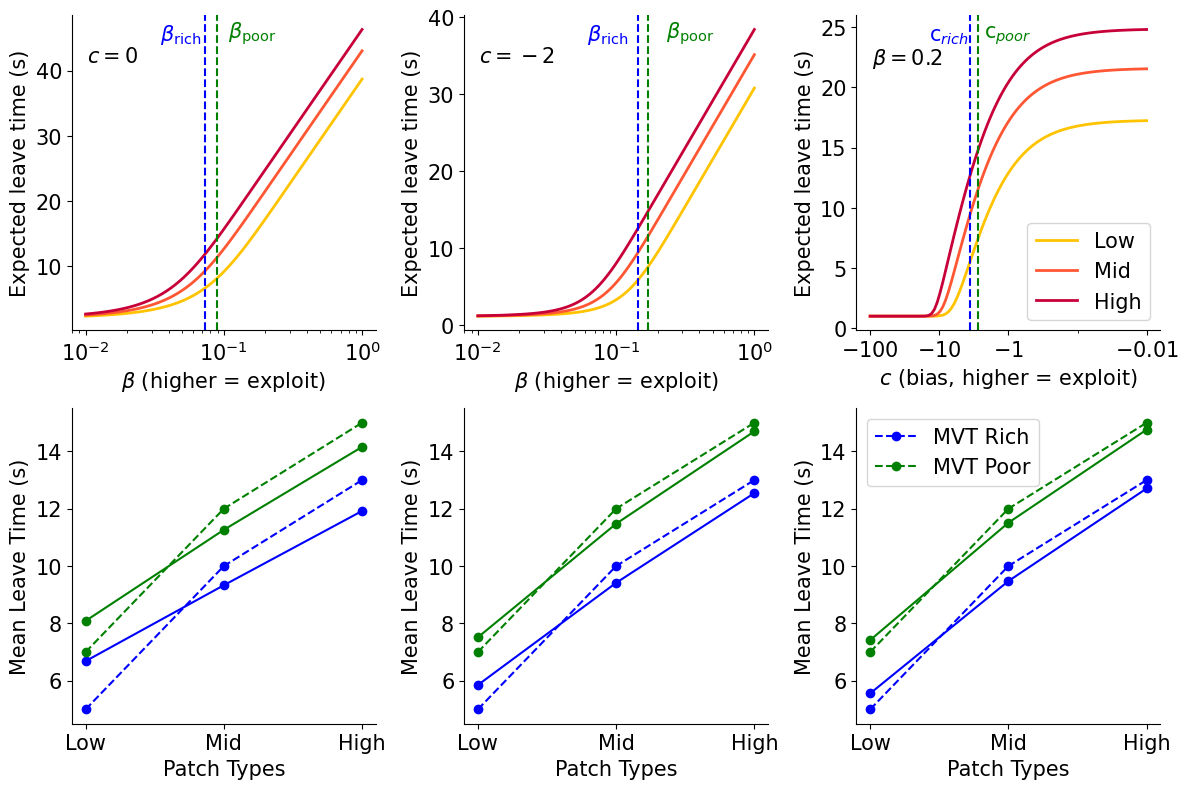

In [188]:
decay_rate = 0.075
model = 'softmax'  # model choices are ['softmax', 'epsilon_greedy', 'mellowmax']

# Parameters for the different models
epsilon_values = [0.1, 0.2, 0.3]  # Only for epsilon-greedy
omega_values = [0.25, 0.5, 0.75]  # Only for mellowmax
beta_values = [0.25, 0.5, 0.75]  # Only for softmax
intercept_values = [-1, 0, 1]  # Only for softmax

mvt_model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = mvt_model.run()

sim = Simulation(
    decay_rate, model, 
    beta_values=beta_values, 
    intercept_values=intercept_values, 
    epsilon_values=epsilon_values, 
    omega_values=omega_values
)

sim.plot_softmax_metric_vs_beta_and_intercept(save_plots=False)

/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:108: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta_hat = fsolve(root_function, initial_guess)
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:93: RuntimeWarning: invalid value encountered in log
  return np.log(np.mean(np.exp(self.omega * Q_values) + self.intercept)) / self.omega
/Users/shayan/Desktop/NOTTS/research_project/foraging/foraging_thesis/exploration_in_foraging/notebooks/../src/world.py:128: RuntimeWarning: overflow encountered in exp
  leave_proba = 1 / (1 + 

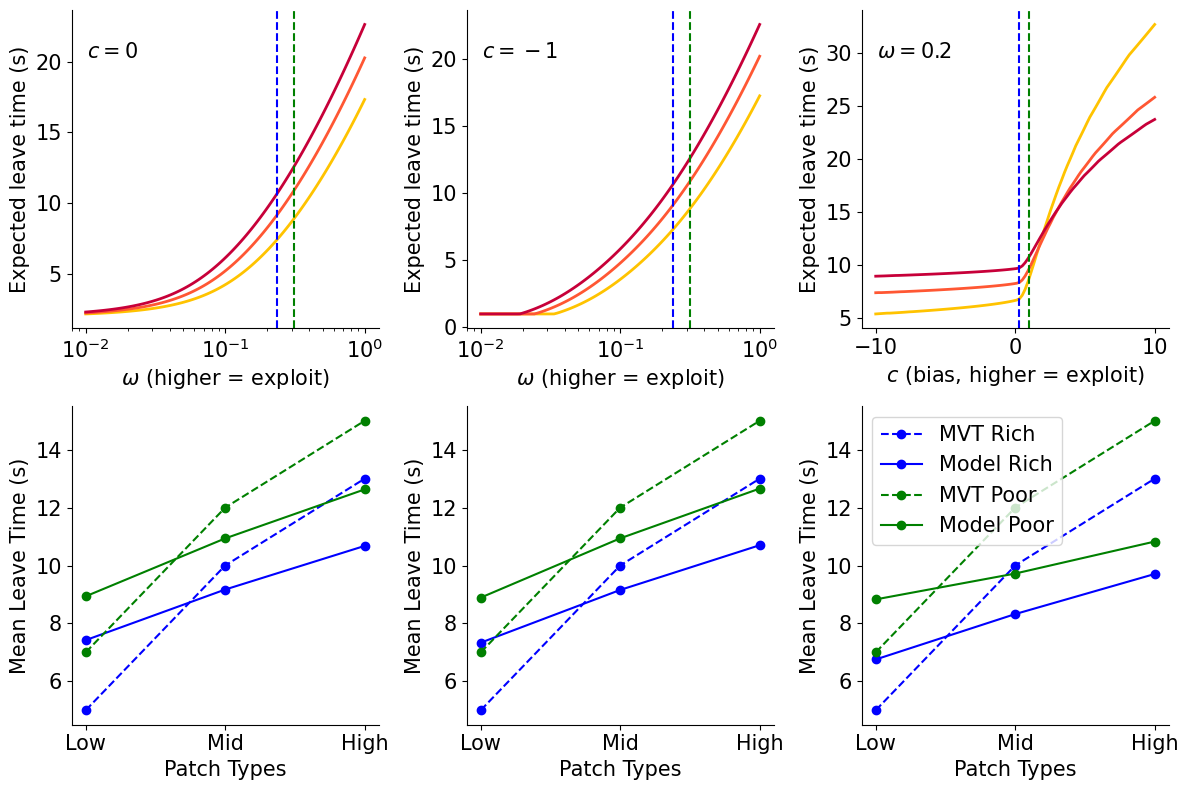

In [190]:
model = "mellowmax"

mvt_model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = mvt_model.run()

sim = Simulation(
    decay_rate, model, 
    beta_values=beta_values, 
    intercept_values=intercept_values, 
    epsilon_values=epsilon_values, 
    omega_values=omega_values
)

sim.plot_mellowmax_leave_time_vs_omega(save_plots=False)